**Connecting to GDrive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [4]:
# Path to the folder containing flower photos
flower_photo_folder = "/content/drive/MyDrive/Colab Notebooks/pictures/"

# Path to the selfie folder
selfie_folder = os.path.join(flower_photo_folder, "selfie")

**Displaying Pictures**

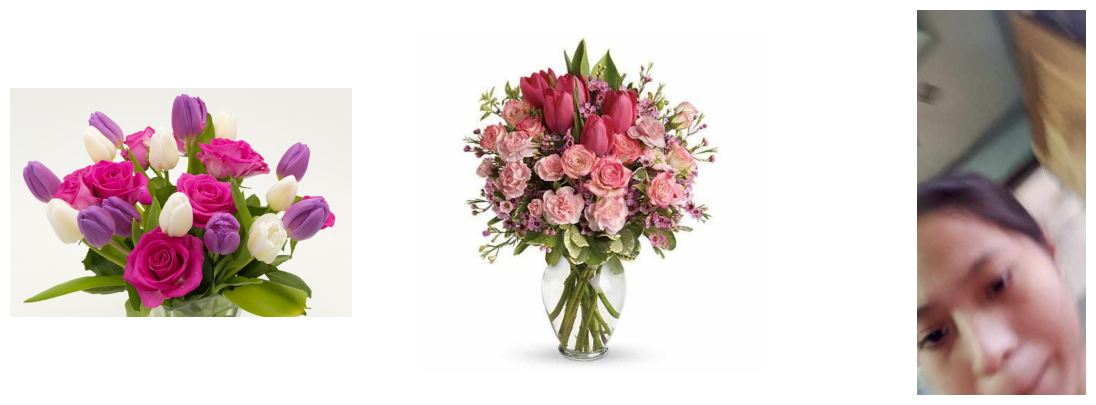

In [10]:
# List of image files
image_files = ["selfie_1.jpg", "selfie_2.jpg", "selfie_3.jpg"]

# Display the images using matplotlib
fig, axes = plt.subplots(1, 3, figsize=(15, 5))  # Create subplots

for i, image_file in enumerate(image_files):
    # Path to the image file
    image_path = os.path.join(selfie_folder, image_file)

    # Read and display the image
    img = mpimg.imread(image_path)
    axes[i].imshow(img)
    axes[i].axis('off')  # Hide axes

plt.show()

**Counting all pictures inside the folder**

In [9]:
import os

flower_photo_folder = "/content/drive/MyDrive/Colab Notebooks/pictures/"

flower_categories = ["selfie"]

image_count = 0

# Iterate through each flower category
for category in flower_categories:
    category_folder = os.path.join(flower_photo_folder, category)
    # Check if category folder exists
    if os.path.exists(category_folder):
        for filename in os.listdir(category_folder):
            if filename.endswith(".jpg") or filename.endswith(".jpeg"):
                image_count += 1

print("Total number of selfie images:", image_count)

Total number of selfie images: 3
